In [1]:
import matplotlib.pyplot as plt
from hmm import *
from pyhmmer.plan7 import *
from phmm2hmm import toHMM
from hmm2smm import to_smm
from smm2encoding import smm_to_autoencoder
from sklearn.preprocessing import normalize
from collections import defaultdict
import editdistance
from seq_split import seq_split_by_hmm_cycles

In [2]:
with HMMFile("data/DF0000014.hmm") as hmm_file:
#with HMMFile("data/sample.hmm") as hmm_file:
    phmm = hmm_file.read()

In [3]:
input_hmm = toHMM(phmm)

In [4]:
smm,smm_encoder,smm_decoder = to_smm(input_hmm, 1/16000)

In [5]:
smm.num_states

1378

In [6]:
decoder = to_decoder(smm, cutoff_prob=1.0/100000, multi_symbol_encoding=True, multi_symbol_depth_limit=3)

In [10]:
simple_transducer = FunctionalRealtimeTransducer({
    0: {0:(0,[2,2,2]),1:(1,[])},
    1: {0:(0,[2,2,3]),1:(2,[])},
    2: {0:(0,[2,3]),1:(0,[3])},
})

In [11]:
inverse_st = reverse_transducer(simple_transducer)

In [12]:
simple_transducer.transcode(inverse_st.transcode([2,3,2,2,2,3,2,2,3,3,2,2,2]))

[2, 3, 2, 2, 2, 3, 2, 2, 3, 3, 2, 2, 2]

In [13]:
encoder = reverse_transducer(decoder)

In [14]:
len(encoder.states)

1569

In [15]:
encoder2 = simplify_transducer(encoder)

In [16]:
len(encoder2.states)

973

In [17]:
decoder.transcode([0,1,0,1,0,0,1,1,0,1,0,1,0], show_trace=True)

([652, 653, 659, 661, 667, 669],
 [(1379, []),
  (3936, []),
  (6837, []),
  (9504, []),
  (13349, []),
  (18347, []),
  (25550, []),
  (649, [652]),
  (657, [653, 659]),
  (2482, []),
  (2481, [661]),
  (5396, []),
  (669, [667, 669])])

In [18]:
encoder.transcode([652, 653, 659, 661, 667, 669])

[0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0]

In [19]:
encoder2.transcode([652, 653, 659, 661, 667, 669])

[0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0]

In [20]:
fasta_file = open("./data/chr11_HSA_simple.fasta")
seqStr = fasta_file.read()
fasta_file.close()

In [21]:
code_map = {'A': 0, 'C': 1, 'G': 2, 'T': 3}
code_seq = np.array([code_map[b] for b in seqStr])
train_seq = code_seq.reshape(1, -1)

In [23]:
stttt = seq_split_by_hmm_cycles(code_seq, input_hmm)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [22]:
(start_dna_seq, dna_seqs, _), (start_state_seq, state_seqs, _) = seq_split_by_hmm_cycles(code_seq, input_hmm)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [ ]:
start_smm_seq = smm_encoder(start_state_seq, start_dna_seq, from_start = False, until_end = False)

In [ ]:
smm_seqs = [smm_encoder(state_seq, dna_seqs[pos], from_start = False, until_end = False) for pos, state_seq in enumerate(state_seqs)]

In [ ]:
encoder_exec = encoder2.get_execution()

In [ ]:
start_code = encoder_exec.read(start_smm_seq)

In [ ]:
codes = [encoder_exec.read(smm_seq) for smm_seq in smm_seqs]

In [ ]:
dna_seq_dists = np.array([editdistance.eval(dna_seq_1, dna_seq_2) for dna_seq_1 in dna_seqs for dna_seq_2 in dna_seqs])
dna_seq_dists.shape = (len(dna_seqs), len(dna_seqs))

(array([  4.,   8.,  11.,  10.,  20.,  21.,  17.,  10.,  21.,  25.,  15.,
         21.,  15.,  18.,  15.,  21.,  27.,  24.,  36.,  28.,  29.,  34.,
         24.,  15.,  10.,  14.,  17.,  17.,  30.,  29.,  29.,  27.,  30.,
         56.,  47.,  55.,  48.,  89.,  96., 113., 150., 148., 204., 201.,
        273., 246., 229., 222., 242., 233., 228., 186., 167., 124., 102.,
         69.,  62.,  47.,  35.,  27.]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
        13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
        26., 27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38.,
        39., 40., 41., 42., 43., 44., 45., 46., 47., 48., 49., 50., 51.,
        52., 53., 54., 55., 56., 57., 58., 59., 60.]),
 <BarContainer object of 60 artists>)

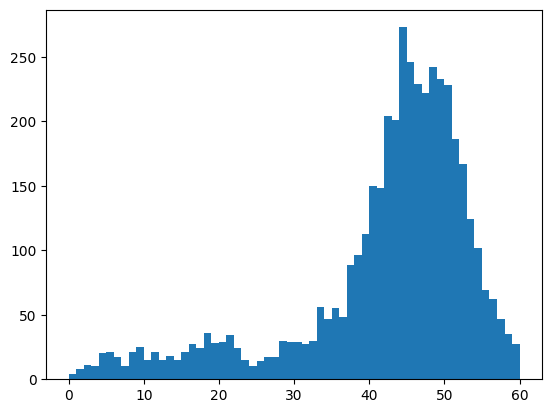

In [ ]:
plt.hist([editdistance.eval(dna_seq_1, dna_seq_2) for position_1, dna_seq_1 in enumerate(dna_seqs) for dna_seq_2 in dna_seqs[position_1 + 1:]], bins=60)

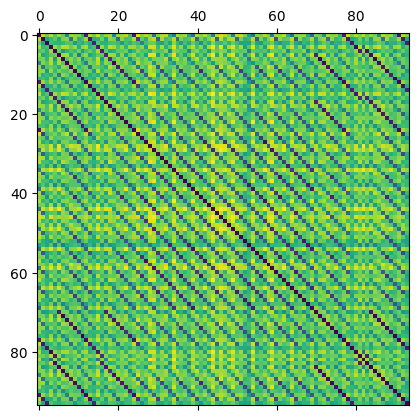

In [ ]:
plt.matshow(dna_seq_dists)

In [ ]:
code_dists = np.array([editdistance.eval(code_1, code_2) for code_1 in codes for code_2 in codes])
code_dists.shape = (len(codes), len(codes))

(array([  4.,   2.,   3.,   3.,   1.,   9.,   4.,   4.,   4.,   6.,  11.,
          4.,  10.,   6.,   7.,   9.,   9.,   4.,   6.,   6.,  10.,   7.,
         10.,   9.,  12.,  11.,  11.,  11.,   9.,  13.,  10.,   8.,  19.,
         17.,  14.,  24.,  22.,  17.,  15.,  16.,  22.,   9.,  18.,  18.,
         16.,  10.,  13.,   9.,  12.,  18.,  20.,  20.,  32.,  30.,  38.,
         30.,  55.,  50.,  55.,  71.,  92., 125., 137., 168., 183., 197.,
        241., 219., 219., 214., 211., 233., 182., 162., 154., 121., 112.,
         91.,  90.,  55.,  43.,  47.,  42.,  27.,  16.,  17.,  15.,   9.,
          5.,   5.,   5.,   3.,   4.,   1.,   1.,   2.]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
        13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
        26., 27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38.,
        39., 40., 41., 42., 43., 44., 45., 46., 47., 48., 49., 50., 51.,
        52., 53., 54., 55., 56., 57., 58., 59., 60., 61., 

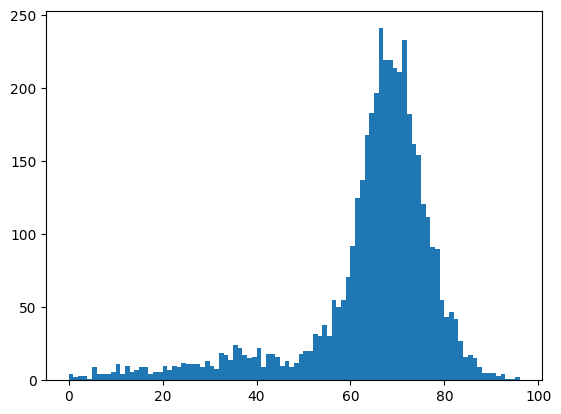

In [ ]:
plt.hist([editdistance.eval(code_1, code_2) for position, code_1 in enumerate(codes) for code_2 in codes[position + 1:]], bins=96)

In [ ]:
sorted([editdistance.eval(code_1, code_2) for position, code_1 in enumerate(codes) for code_2 in codes[position + 1:]])[200:]

[28,
 28,
 29,
 29,
 29,
 29,
 29,
 29,
 29,
 29,
 29,
 29,
 29,
 29,
 29,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 31,
 31,
 31,
 31,
 31,
 31,
 31,
 31,
 32,
 32,
 32,
 32,
 32,
 32,
 32,
 32,
 32,
 32,
 32,
 32,
 32,
 32,
 32,
 32,
 32,
 32,
 32,
 33,
 33,
 33,
 33,
 33,
 33,
 33,
 33,
 33,
 33,
 33,
 33,
 33,
 33,
 33,
 33,
 33,
 34,
 34,
 34,
 34,
 34,
 34,
 34,
 34,
 34,
 34,
 34,
 34,
 34,
 34,
 35,
 35,
 35,
 35,
 35,
 35,
 35,
 35,
 35,
 35,
 35,
 35,
 35,
 35,
 35,
 35,
 35,
 35,
 35,
 35,
 35,
 35,
 35,
 35,
 36,
 36,
 36,
 36,
 36,
 36,
 36,
 36,
 36,
 36,
 36,
 36,
 36,
 36,
 36,
 36,
 36,
 36,
 36,
 36,
 36,
 36,
 37,
 37,
 37,
 37,
 37,
 37,
 37,
 37,
 37,
 37,
 37,
 37,
 37,
 37,
 37,
 37,
 37,
 38,
 38,
 38,
 38,
 38,
 38,
 38,
 38,
 38,
 38,
 38,
 38,
 38,
 38,
 38,
 39,
 39,
 39,
 39,
 39,
 39,
 39,
 39,
 39,
 39,
 39,
 39,
 39,
 39,
 39,
 39,
 40,
 40,
 40,
 40,
 40,
 40,
 40,
 40,
 40,
 40,
 40,
 40,
 40,
 40,
 40,
 40,
 40,
 40,
 40,
 40,
 40,
 40,
 41,


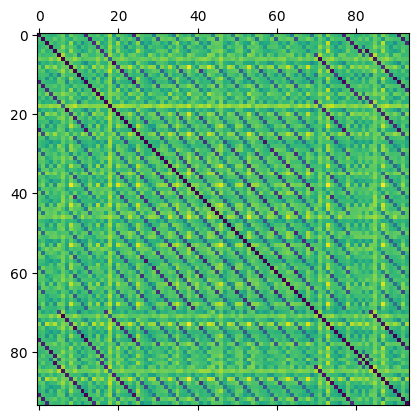

In [ ]:
plt.matshow(code_dists)

In [ ]:
def matrix_closure(matrix):
    matrix_closure = matrix
    while True:
        new_matrix_closure = matrix_closure | np.matmul(matrix_closure, matrix)
        if np.array_equal(new_matrix_closure, matrix_closure):
            break
        matrix_closure = new_matrix_closure
        # print(matrix_closure)
    return matrix_closure

In [ ]:
m = dna_seq_dis

In [ ]:
m + 0

array([[1, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 0, 1]])

In [ ]:
m3 = m2 | (m2 * m)

In [ ]:
(m2 ^ m).any()

False

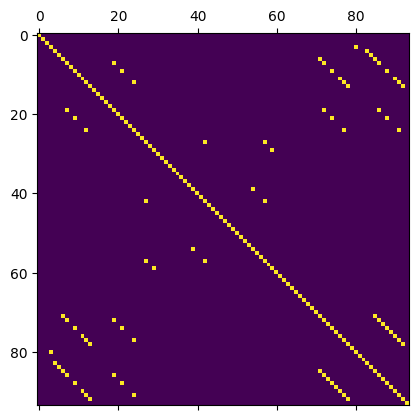

In [ ]:
plt.matshow(matrix_closure(dna_seq_dists<=3))

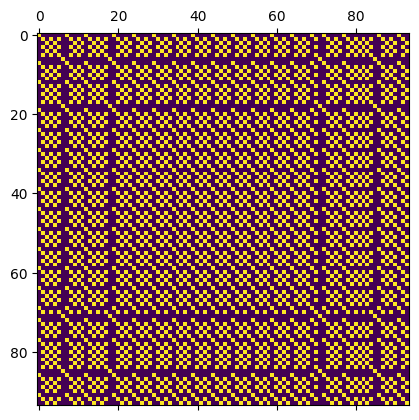

In [ ]:
plt.matshow(matrix_closure(code_dists<=50))

In [ ]:
def connected_components(adjacency_matrix, min_size=2):
    reachability_matrix = matrix_closure(adjacency_matrix)
    components = {}
    for curr_node in range(adjacency_matrix.shape[0]):
        existing_cluster_found = False
        for prev_node in range(curr_node):
            # print("Checking " + str(curr_node) + " against " + str(prev_node))
            if reachability_matrix[curr_node][prev_node] == 1:
                # print("Append " + str(curr_node) + " to " + str(prev_node))
                components[prev_node].append(curr_node)
                existing_cluster_found = True
                break
        if not existing_cluster_found:
            # print("Add " + str(curr_node))
            components[curr_node] = [curr_node]
    return [component for component in components.values() if len(component) >= min_size]

In [ ]:
matrix_closure(dna_seq_dists<=27)

array([[ True, False, False, ...,  True, False, False],
       [False,  True, False, ..., False,  True, False],
       [False, False,  True, ..., False, False,  True],
       ...,
       [ True, False, False, ...,  True, False, False],
       [False,  True, False, ..., False,  True, False],
       [False, False,  True, ..., False, False,  True]])

In [ ]:
matrix_closure(dna_seq_dists<=27)[10]

array([False, False, False, False, False,  True, False, False, False,
       False,  True, False, False, False, False, False, False,  True,
       False, False, False, False,  True, False, False, False, False,
        True, False, False, False, False,  True, False, False, False,
       False,  True, False, False, False, False,  True, False, False,
       False, False,  True, False, False, False, False,  True, False,
       False, False, False,  True, False, False, False, False,  True,
       False, False, False, False,  True, False, False,  True, False,
       False, False, False,  True, False, False, False, False, False,
       False, False, False,  True, False, False, False, False,  True,
       False, False, False, False])

In [ ]:
dna_seq_clusters = connected_components(dna_seq_dists<=25, min_size=1)

In [ ]:
code_big_clusters = connected_components(code_dists<=50)

In [ ]:
dna_seq_clusters

[[0, 7, 12, 19, 24, 29, 34, 39, 44, 49, 54, 59, 64, 69, 72, 77, 86, 91],
 [1, 8, 13, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 73, 78, 87, 92],
 [2, 14, 79, 93],
 [3, 15, 80, 82],
 [4, 16, 81, 83],
 [5, 10, 17, 22, 27, 32, 37, 42, 47, 52, 57, 62, 67, 70, 75, 84, 89],
 [6, 11, 18, 23, 28, 33, 38, 43, 48, 53, 58, 63, 68, 71, 76, 85, 90],
 [9, 21, 26, 31, 36, 41, 46, 51, 56, 61, 66, 74, 88]]

In [ ]:
code_big_clusters

[[0, 7, 12, 19, 24, 29, 34, 39, 44, 49, 54, 59, 64, 69, 72, 77, 86, 91],
 [1,
  3,
  5,
  8,
  10,
  13,
  15,
  17,
  20,
  22,
  25,
  27,
  30,
  32,
  35,
  37,
  40,
  42,
  45,
  47,
  50,
  52,
  55,
  57,
  60,
  62,
  65,
  67,
  70,
  73,
  75,
  78,
  80,
  82,
  84,
  87,
  89,
  92],
 [2,
  4,
  9,
  11,
  14,
  16,
  21,
  23,
  26,
  28,
  31,
  33,
  36,
  38,
  41,
  43,
  46,
  48,
  51,
  53,
  56,
  58,
  61,
  63,
  66,
  68,
  74,
  76,
  79,
  81,
  83,
  88,
  90,
  93],
 [6, 18, 71, 85]]

In [ ]:
seq_to_cluster = {seq_index:cluster_index for cluster_index, cluster in enumerate(dna_seq_clusters) for seq_index in cluster}

In [ ]:
seq_to_big_cluster = {seq_index:cluster_index for cluster_index, cluster in enumerate(code_big_clusters) for seq_index in cluster}

In [ ]:
[seq_pos for seq_pos in range(len(dna_seqs)) if seq_pos not in seq_to_cluster]

[]

In [ ]:
"".join([chr(65 + seq_to_cluster[seq_pos]) if seq_pos in seq_to_cluster else '-' for seq_pos in range(len(dna_seqs))])

'ABCDEFGABHFGABCDEFGABHFGABHFGABHFGABHFGABHFGABHFGABHFGABHFGABHFGABHFGAFGABHFGABCDEDEFGABHFGABC'

In [ ]:
"".join([chr(65 + seq_to_big_cluster[seq_pos]) if seq_pos in seq_to_big_cluster else '-' for seq_pos in range(len(dna_seqs))])

'ABCBCBDABCBCABCBCBDABCBCABCBCABCBCABCBCABCBCABCBCABCBCABCBCABCBCABCBCABDABCBCABCBCBCBDABCBCABC'

In [ ]:
len(dna_seq_clusters)

11

(array([5., 1., 0., 0., 1., 0., 2., 1., 0., 1.]),
 array([ 4. ,  5.3,  6.6,  7.9,  9.2, 10.5, 11.8, 13.1, 14.4, 15.7, 17. ]),
 <BarContainer object of 10 artists>)

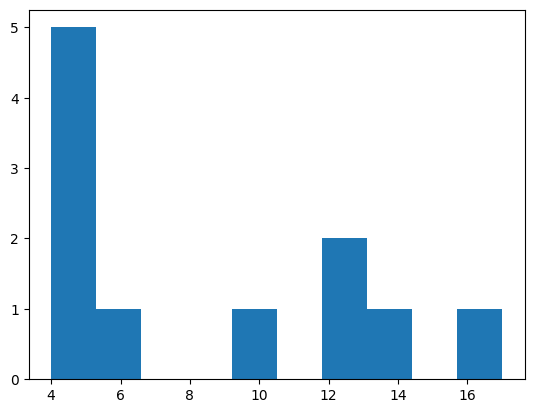

In [ ]:
plt.hist([len(cluster) for cluster in dna_seq_clusters])

In [ ]:
[i for i in range(0)]

[]

In [ ]:
start_code

[1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0]

In [ ]:
log_prob / np.log(2)

-21443.11549625917

In [ ]:
- train_seq.size * 2

-32070

In [ ]:
smm_seq = smm_encoder(state_sequence, train_seq[0])

In [ ]:
model_seq = encoder.transcode(smm_seq[1:])

In [ ]:
model_str = ''.join([str(bit) for bit in model_seq])

In [ ]:
len(model_seq)

21924